In [11]:
%load_ext autoreload
%autoreload 2

import detectron2
from detectron2.utils.logger import setup_logger

setup_logger()
import cv2
import pandas as pd
from detectron2.data import MetadataCatalog
import torch
from utils import read_json, get_instance_pretrained_predictor, cv2_imshow, predict_instance_segmentation
import numpy as np
from tqdm import tqdm

In [81]:
mapping = read_json('mapping.json')
color_mapping = mapping['color_mapping']
class_mapping = mapping['class_mapping']
coco_classes = mapping['coco_classes']
cfg, predictor = get_instance_pretrained_predictor()

In [119]:
dataset = 'super-robust'
img_dir = f'../data/{dataset}/rgb/'
gt_dir = f'../data/{dataset}/semantic/'
acc = {c: [] for c in color_mapping}
for img_idx in tqdm(range(5600)):
# read image and convert to rgb
    im = cv2.imread(f'{img_dir}/{img_idx:06}.png')[:, :, ::-1]
    gt = cv2.imread(f'{gt_dir}/{img_idx:06}.png')[:, :, ::-1]


    # predictor takes BGR value
    output = predictor(im[:, :, ::-1])
    instances = set([class_mapping[coco_classes[i]] for i in output['instances'].pred_classes.cpu() if
                 coco_classes[i] in class_mapping])

    for name, color in color_mapping.items():
        # check if a pixel represent the class exists
        type_exists = np.all(gt == color, axis=2).any()
        if type_exists == (name in instances):
            acc[name].append(1)
        else:
            acc[name].append(0)


  0%|          | 0/5600 [00:00<?, ?it/s]c:\users\chenp\documents\github\detectron2\detectron2\structures\image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
100%|██████████| 5600/5600 [15:00<00:00,  6.22it/s]


In [120]:
for t in acc:
    print(t)
    print(sum(acc[t]) / len(acc[t]))

pedestrian
0.7628571428571429
vehicle
0.9996428571428572
traffic light
0.5807142857142857


In [121]:
acc_df = pd.DataFrame(acc)
acc_df.to_csv(f'{dataset}.csv', index=None)

Instances(num_instances=5, image_height=720, image_width=1280, fields=[pred_boxes: Boxes(tensor([[  38.5289,  346.7442,  252.6508,  429.8230],
        [ 580.2855,  364.8600,  678.7281,  436.7513],
        [1010.3669,    4.0673, 1274.3734,  298.4798],
        [ 582.8107,  364.9237,  678.9636,  441.5102],
        [ 273.8103,  324.2180,  295.5270,  391.0560]], device='cuda:0')), scores: tensor([0.9957, 0.8007, 0.7886, 0.6329, 0.6087], device='cuda:0'), pred_classes: tensor([ 2,  2, 25, 28,  0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, 

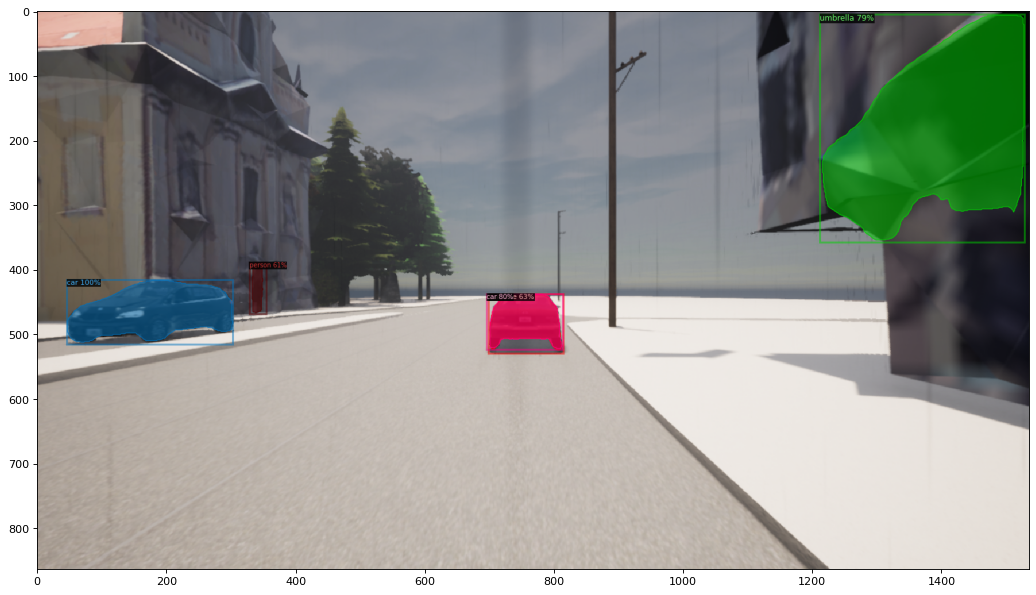

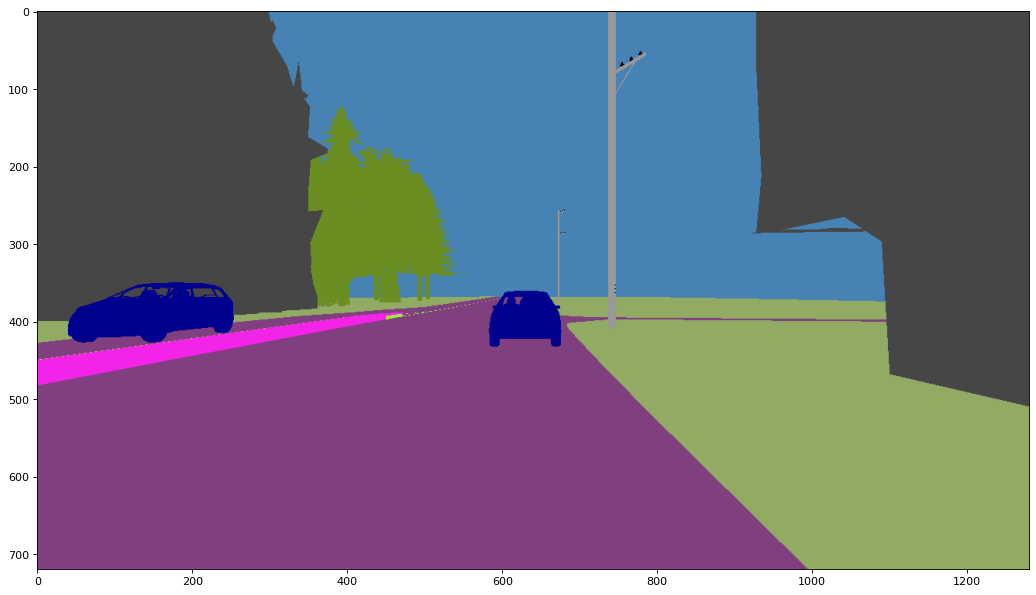

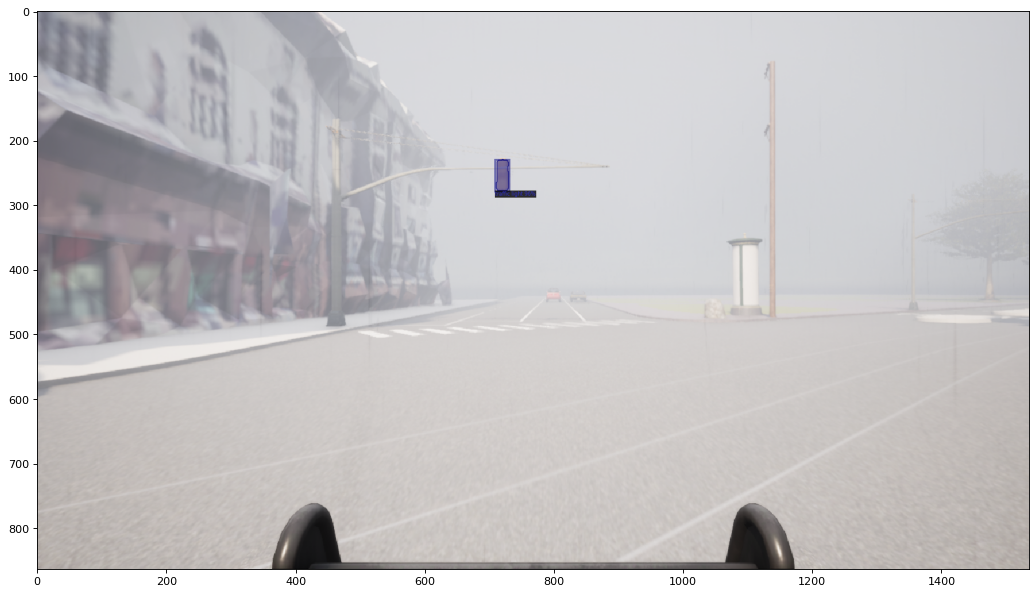

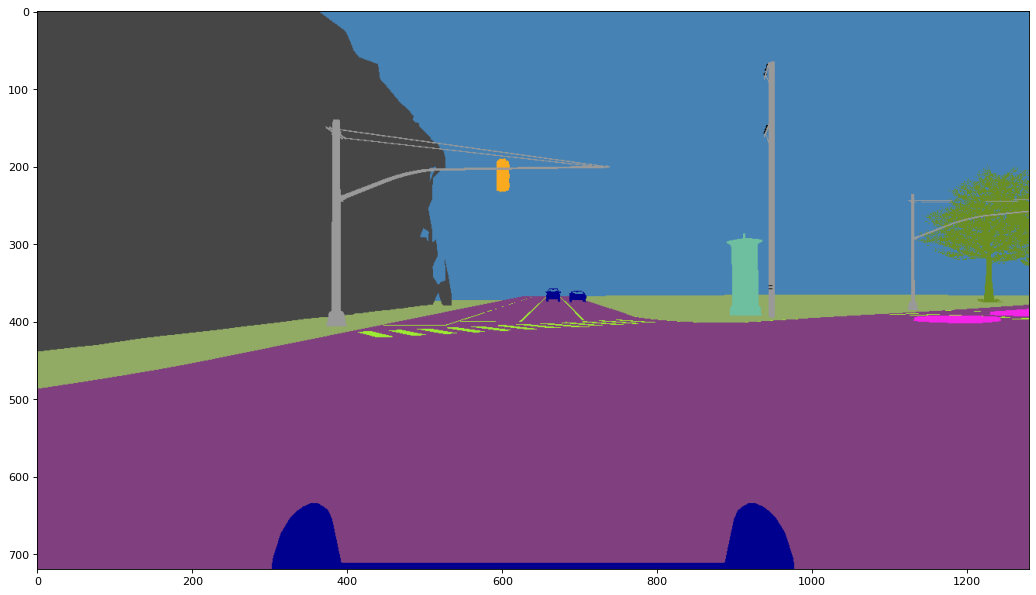

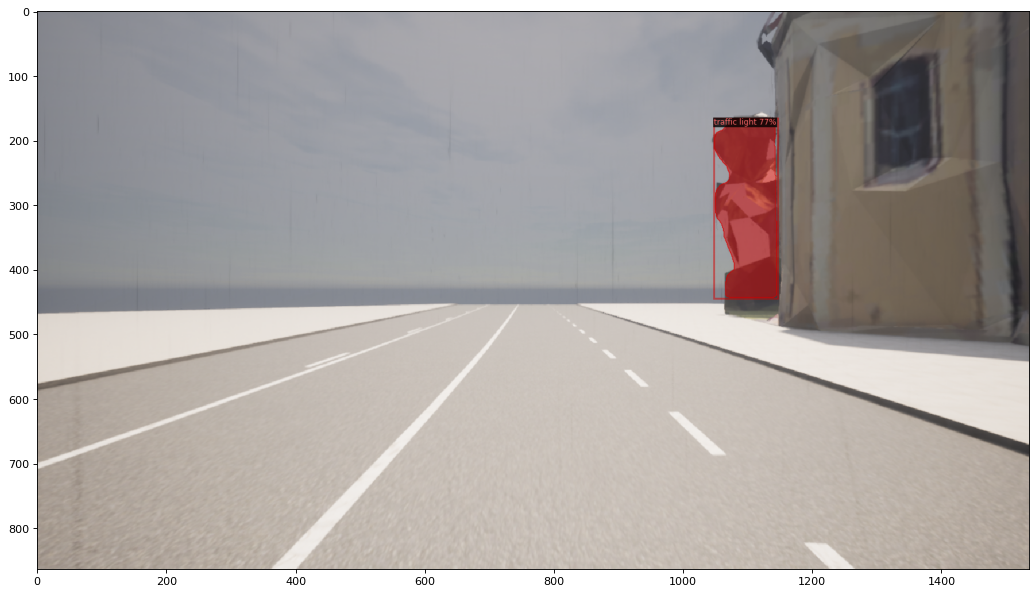

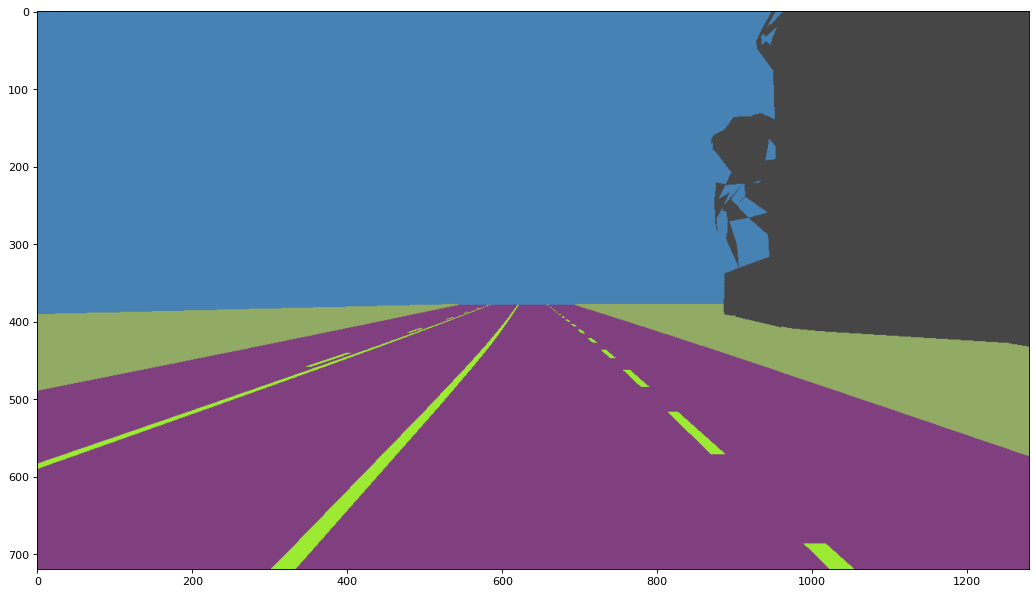

In [105]:
for t in acc:
    img_idx = acc[t].index(0)
    im = cv2.imread(f'{img_dir}/{img_idx:06}.png')[:, :, ::-1]
    gt = cv2.imread(f'{gt_dir}/{img_idx:06}.png')[:, :, ::-1]
    out = predict_instance_segmentation(im[:, :, ::-1], predictor, cfg)
    cv2_imshow(out.get_image()[:, :, ::-1])
    cv2_imshow(gt[:, :, ::-1])

In [9]:
from scene_parse.object_detector.datasets import CarlaDataset
from scene_parse.object_detector.models import get_pretrained_mask_rcnn
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
import os
import random
from detectron2.utils.visualizer import Visualizer
import cv2

In [2]:
dataset = CarlaDataset()
categories = dataset.get_categories()

In [3]:
DatasetCatalog.register("carla", dataset.dataset_loader('C:/Users/chenp/Documents/github/Clevr-Relational/data/instance-segmentation/rbg', 'C:/Users/chenp/Documents/github/Clevr-Relational/data/instance-segmentation/scenes.json'))
MetadataCatalog.get("carla").set(thing_classes=categories)

loading dataset: 100%|██████████| 200/200 [00:01<00:00, 171.40it/s]


namespace(name='carla', thing_classes=['car'])

loading dataset: 100%|██████████| 200/200 [00:00<00:00, 211.98it/s]


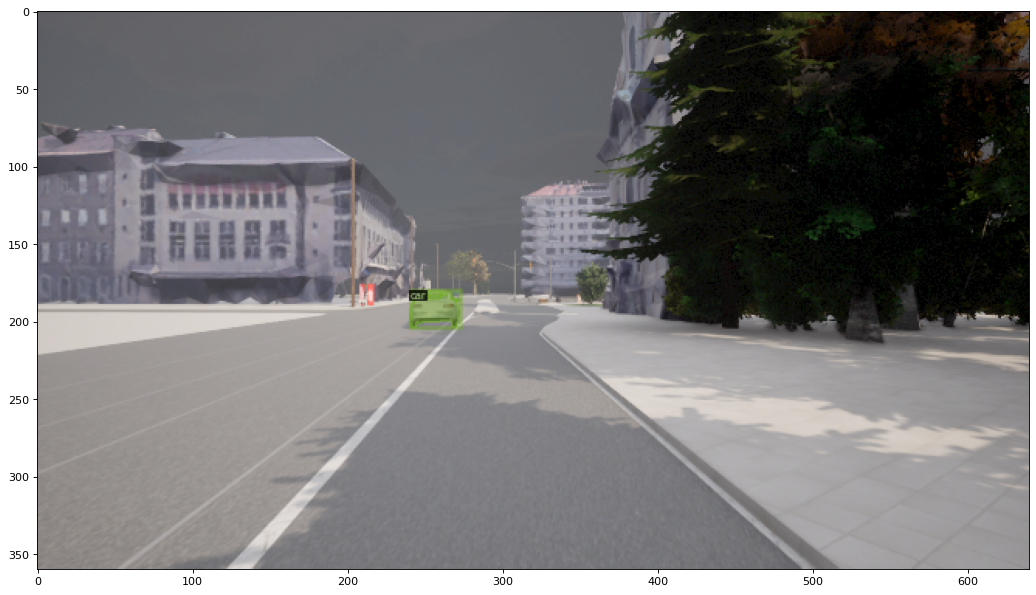

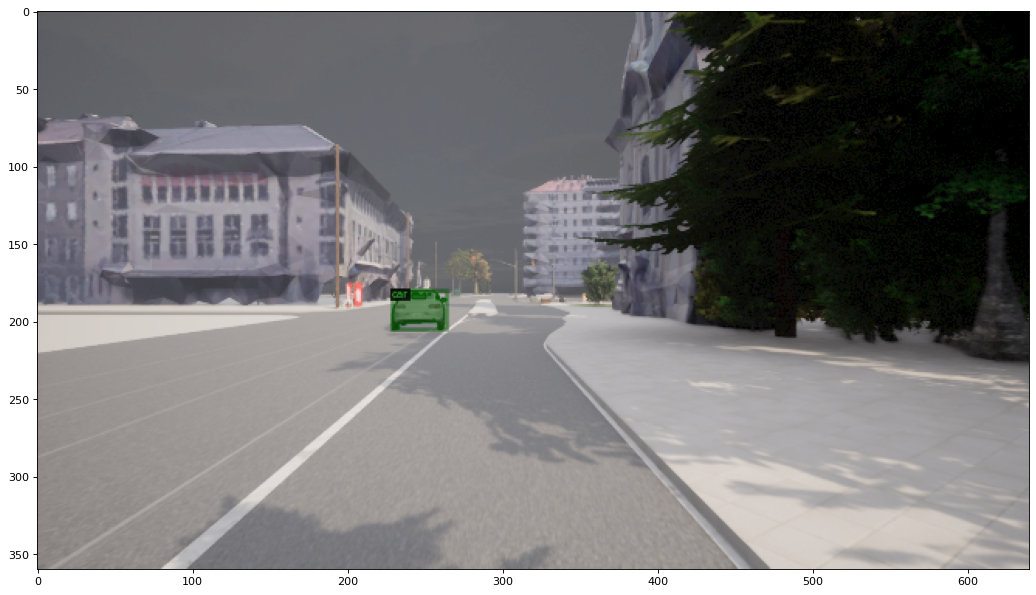

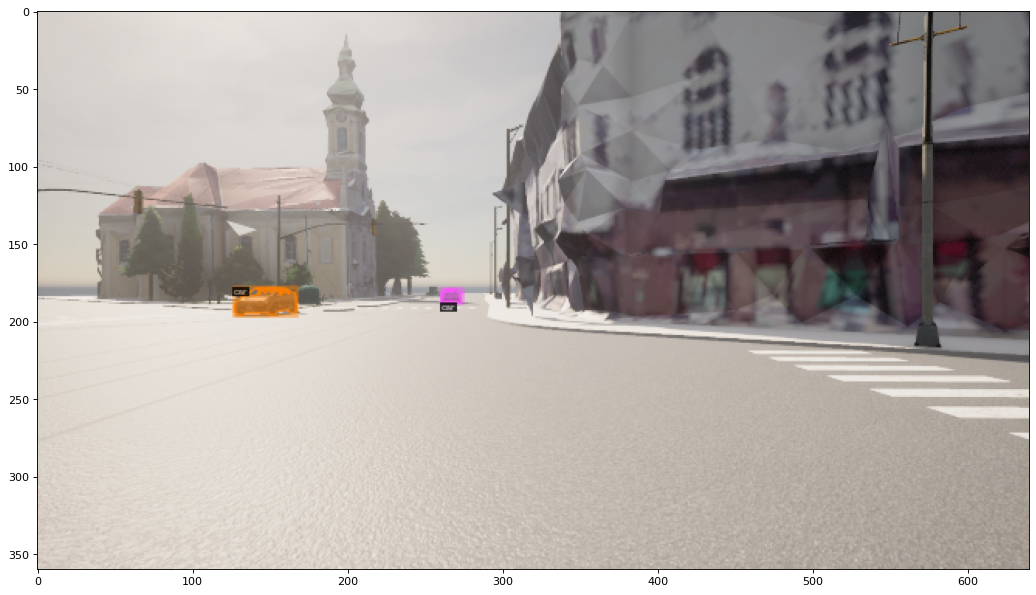

In [14]:
dataset_dicts = dataset.dataset_loader('C:/Users/chenp/Documents/github/Clevr-Relational/data/instance-segmentation/rgb', 'C:/Users/chenp/Documents/github/Clevr-Relational/data/instance-segmentation/scenes.json')()
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("carla"), scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [4]:
cfg = get_pretrained_mask_rcnn('carla', len(categories), max_iter=1000)

cfg.OUTPUT_DIR = './data/object_detector_carla/'

In [5]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()